In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [51]:

# Step 1: Read the image
img = cv.imread(r'm:\yolo project\yolodetect\receipts_yolov8\cropped\receipt_23.jpg')

In [52]:
# Step 2: Reshape the image to a 2D array of pixels (3 values for BGR)
Z = img.reshape((-1, 3))
Z = np.float32(Z)
print(Z)

[[55. 77. 83.]
 [57. 79. 85.]
 [62. 81. 88.]
 ...
 [11. 13. 13.]
 [11. 13. 13.]
 [11. 13. 13.]]


In [53]:
# Step 3: Define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2  # Try different values like 2, 4, 6 etc.
attempts = 10
ret, label, center = cv.kmeans(Z, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)


In [54]:
# Step 4: Convert back into uint8 and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

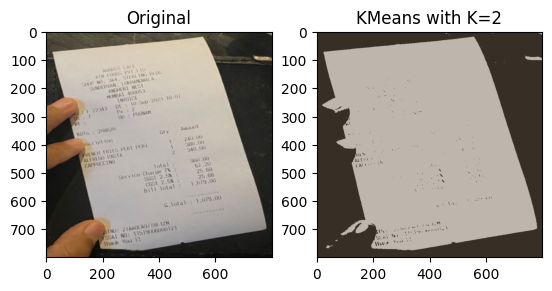

In [55]:
# Step 5: Show original and result
plt.subplot(121), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(122), plt.imshow(cv.cvtColor(res2, cv.COLOR_BGR2RGB)), plt.title(f'KMeans with K={K}')
plt.show()

In [56]:
# Step 5: Convert to grayscale for thresholding
gray = cv.cvtColor(res2, cv.COLOR_BGR2GRAY)

In [57]:

# Step 6: Apply threshold
_, mask = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

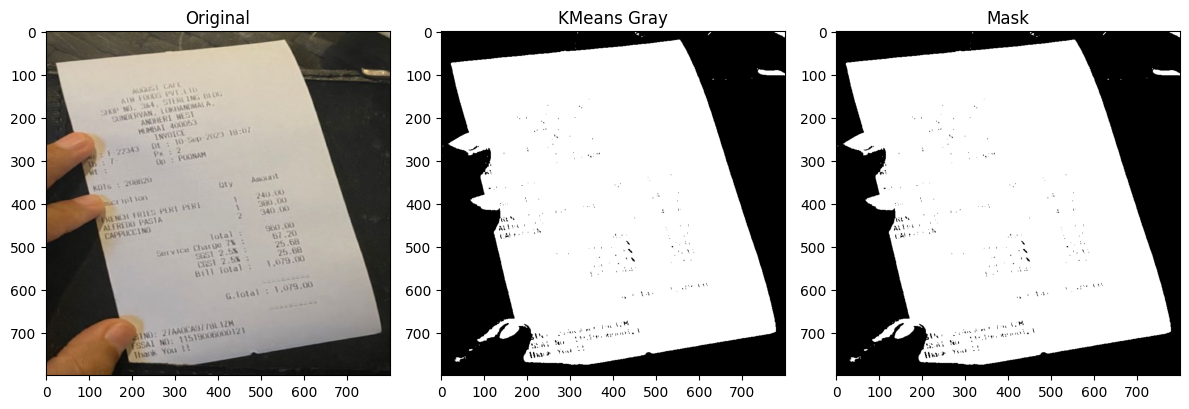

In [58]:

# Step 7: Show results
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.title("Original")
plt.subplot(132), plt.imshow(gray, cmap='gray'), plt.title("KMeans Gray")
plt.subplot(133), plt.imshow(mask, cmap='gray'), plt.title("Mask")
plt.tight_layout()
plt.show()

In [59]:
# Step 4: Apply mask to original image — keep white area, remove black
cleaned = cv.bitwise_and(img, img, mask=mask)

# Optional: Make removed area white instead of black (if needed)
background_white = np.full_like(img, 255)
final = np.where(mask[:, :, None] == 255, cleaned, background_white)

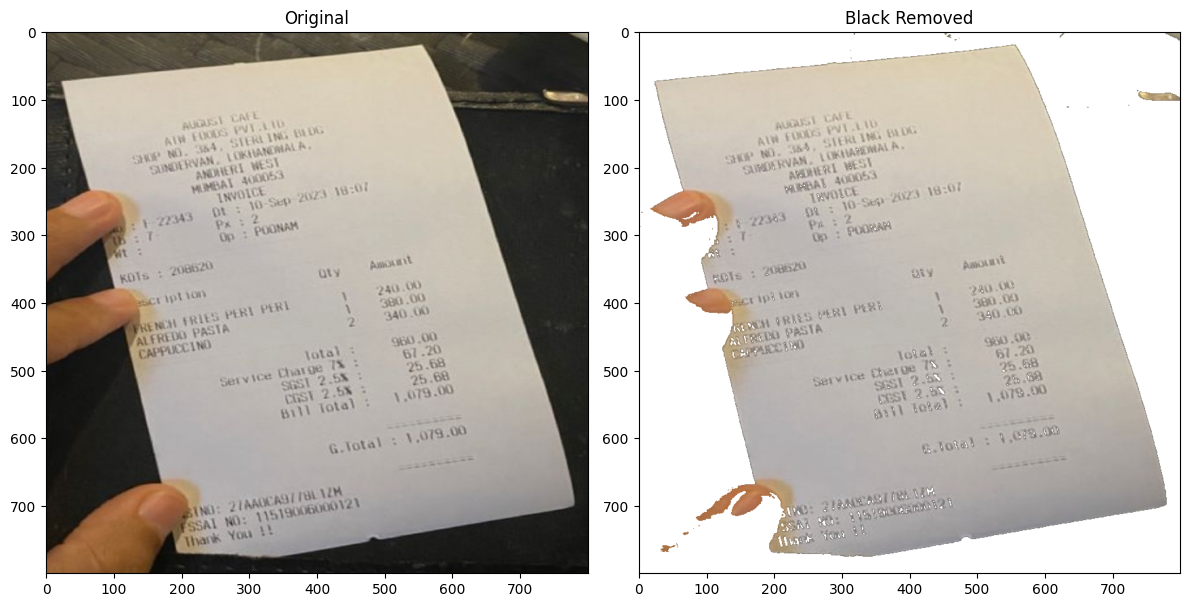

In [60]:
# Show Result
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.title("Original")
plt.subplot(122), plt.imshow(cv.cvtColor(final, cv.COLOR_BGR2RGB)), plt.title("Black Removed")
plt.tight_layout()
plt.show()

Could not find 4 corners. Found 5 corners.
Trying with alternative method...


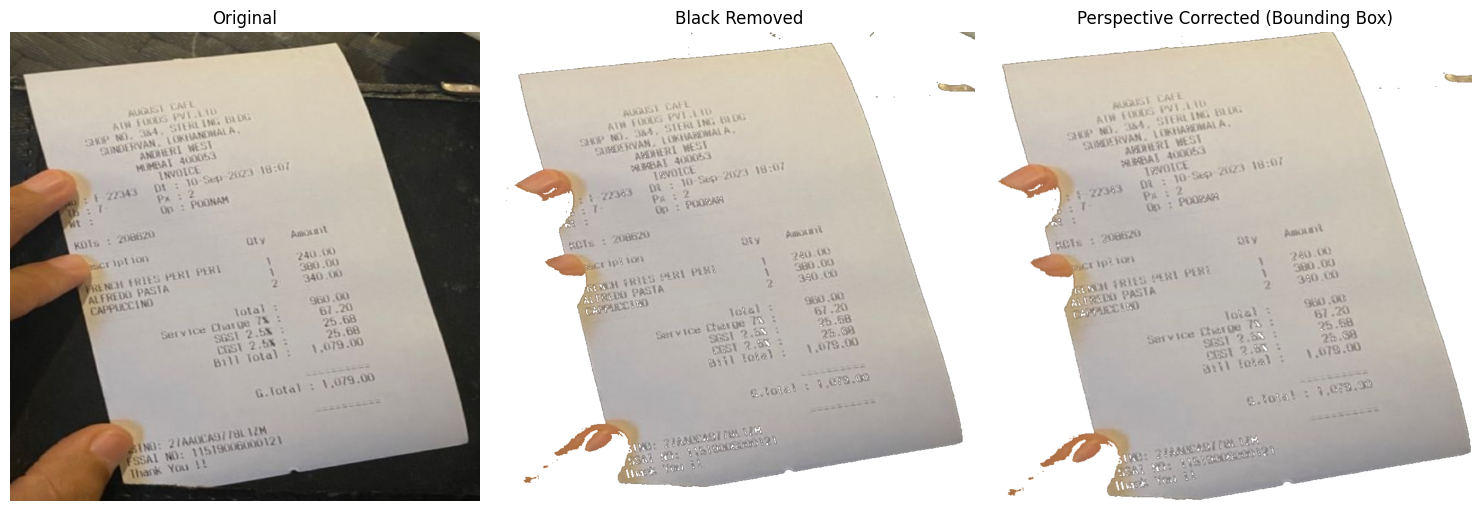

In [72]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

def order_points(pts):
    """Order points in top-left, top-right, bottom-right, bottom-left order"""
    rect = np.zeros((4, 2), dtype="float32")
    
    # Sum and difference to find corners
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    
    # Top-left will have smallest sum, bottom-right will have largest sum
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # Top-right will have smallest difference, bottom-left will have largest difference
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def four_point_transform(image, pts):
    """Apply perspective transformation"""
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Compute width and height of new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # Destination points for the "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    
    # Compute perspective transform matrix and apply it
    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

# Load image
img = cv.imread(r'm:\yolo project\yolodetect\receipts_yolov8\cropped\receipt_23.jpg')
original = img.copy()

# Step 1: Remove black background using K-means clustering
Z = img.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts = 10
ret, label, center = cv.kmeans(Z, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

# Convert to grayscale for thresholding
gray = cv.cvtColor(res2, cv.COLOR_BGR2GRAY)

# Apply threshold
_, mask = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Apply mask to original image
cleaned = cv.bitwise_and(img, img, mask=mask)

# Make background white
background_white = np.full_like(img, 255)
final_cleaned = np.where(mask[:, :, None] == 255, cleaned, background_white)

# Step 2: Find contours for perspective transformation
# Convert cleaned image to grayscale
gray_cleaned = cv.cvtColor(final_cleaned, cv.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv.GaussianBlur(gray_cleaned, (5, 5), 0)

# Apply threshold to get binary image
_, thresh = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# Find contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Step 3: Find the largest contour (should be the receipt)
if contours:
    # Sort contours by area and get the largest one
    largest_contour = max(contours, key=cv.contourArea)
    
    # Approximate the contour to get 4 corners
    epsilon = 0.02 * cv.arcLength(largest_contour, True)
    approx = cv.approxPolyDP(largest_contour, epsilon, True)
    
    # If we found 4 corners, apply perspective transformation
    if len(approx) == 4:
        # Reshape for perspective transform
        pts = approx.reshape(4, 2)
        
        # Apply perspective transformation
        warped = four_point_transform(final_cleaned, pts)
        
        # Display results
        plt.figure(figsize=(18, 6))
        
        plt.subplot(141)
        plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(cv.cvtColor(final_cleaned, cv.COLOR_BGR2RGB))
        plt.title("Black Removed")
        plt.axis('off')
        
        # Show contour detection
        contour_img = final_cleaned.copy()
        cv.drawContours(contour_img, [approx], -1, (0, 255, 0), 3)
        plt.subplot(143)
        plt.imshow(cv.cvtColor(contour_img, cv.COLOR_BGR2RGB))
        plt.title("Detected Corners")
        plt.axis('off')
        
        plt.subplot(144)
        plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
        plt.title("Perspective Corrected")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("Perspective transformation successful!")
        print(f"Original size: {original.shape}")
        print(f"Warped size: {warped.shape}")
        
    else:
        print(f"Could not find 4 corners. Found {len(approx)} corners.")
        print("Trying with alternative method...")
        
        # Alternative: Use bounding rectangle
        x, y, w, h = cv.boundingRect(largest_contour)
        pts = np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]], dtype="float32")
        warped = four_point_transform(final_cleaned, pts)
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(cv.cvtColor(final_cleaned, cv.COLOR_BGR2RGB))
        plt.title("Black Removed")
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
        plt.title("Perspective Corrected (Bounding Box)")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

else:
    print("No contours found!")
    # Just show black removal result
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv.cvtColor(final_cleaned, cv.COLOR_BGR2RGB))
    plt.title("Black Removed")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Optional: Save the results
# cv.imwrite('cleaned_receipt.jpg', final_cleaned)
# if 'warped' in locals():
#     cv.imwrite('perspective_corrected_receipt.jpg', warped)

Found 4 corners with epsilon factor: 0.015


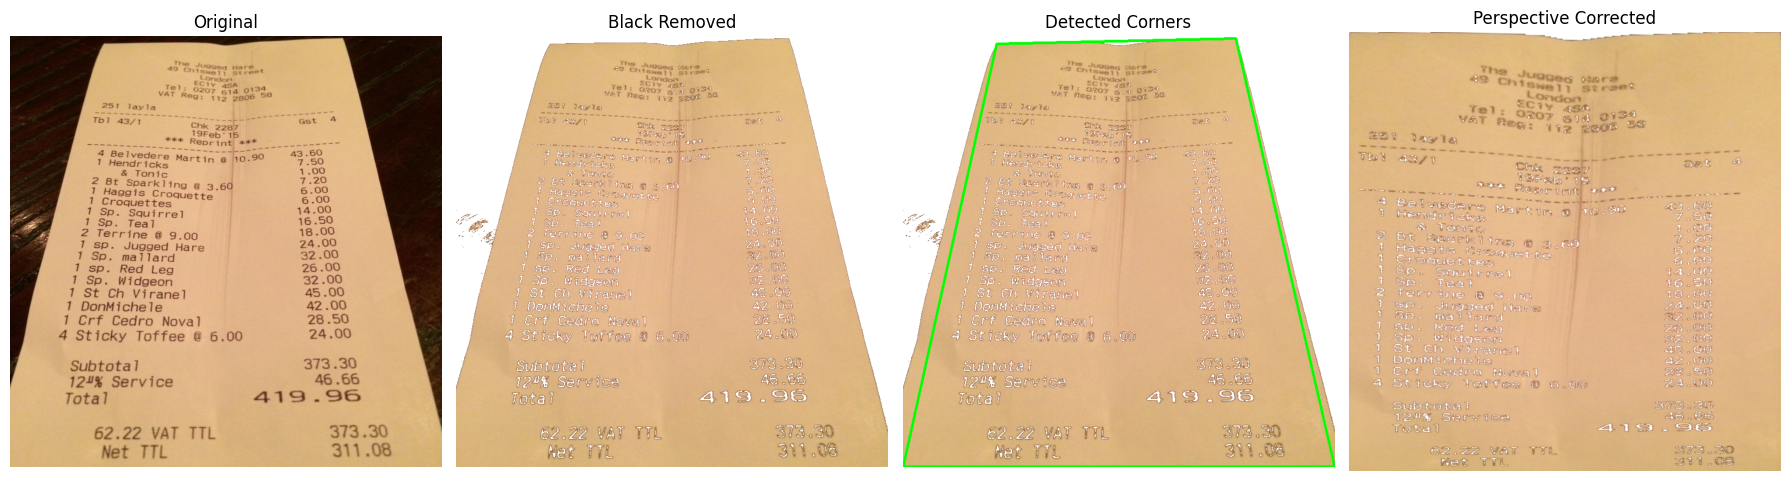

Perspective transformation successful!
Original size: (800, 800, 3)
Warped size: (813, 799, 3)


In [6]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

def order_points(pts):
    """Order points in top-left, top-right, bottom-right, bottom-left order"""
    rect = np.zeros((4, 2), dtype="float32")
    
    # Sum and difference to find corners
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    
    # Top-left will have smallest sum, bottom-right will have largest sum
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # Top-right will have smallest difference, bottom-left will have largest difference
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def four_point_transform(image, pts):
    """Apply perspective transformation"""
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Compute width and height of new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # Destination points for the "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    
    # Compute perspective transform matrix and apply it
    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

# Load image
img = cv.imread(r'M:\yolo project\yolodetect\receipts_yolov8\cropped\receipt_27.jpg')
original = img.copy()

# Step 1: Remove black background using K-means clustering
Z = img.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts = 10
ret, label, center = cv.kmeans(Z, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

# Convert to grayscale for thresholding
gray = cv.cvtColor(res2, cv.COLOR_BGR2GRAY)

# Apply threshold
_, mask = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Apply mask to original image
cleaned = cv.bitwise_and(img, img, mask=mask)

# Make background white
background_white = np.full_like(img, 255)
final_cleaned = np.where(mask[:, :, None] == 255, cleaned, background_white)

# Step 2: Find contours for perspective transformation
# Convert cleaned image to grayscale
gray_cleaned = cv.cvtColor(final_cleaned, cv.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv.GaussianBlur(gray_cleaned, (5, 5), 0)

# Apply threshold to get binary image
_, thresh = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# Find contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Step 3: Find the largest contour (should be the receipt)
if contours:
    # Sort contours by area and get the largest one
    largest_contour = max(contours, key=cv.contourArea)
    
    # Try multiple epsilon values to get 4 corners
    best_approx = None
    for epsilon_factor in [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05]:
        epsilon = epsilon_factor * cv.arcLength(largest_contour, True)
        approx = cv.approxPolyDP(largest_contour, epsilon, True)
        
        if len(approx) == 4:
            best_approx = approx
            print(f"Found 4 corners with epsilon factor: {epsilon_factor}")
            break
        elif len(approx) < 4:
            # If we get less than 4, previous one was better
            break
    
    # If we found 4 corners, apply perspective transformation
    if best_approx is not None and len(best_approx) == 4:
        # Reshape for perspective transform
        pts = best_approx.reshape(4, 2)
        
        # Apply perspective transformation
        warped = four_point_transform(final_cleaned, pts)
        
        # Display results
        plt.figure(figsize=(18, 6))
        
        plt.subplot(141)
        plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(cv.cvtColor(final_cleaned, cv.COLOR_BGR2RGB))
        plt.title("Black Removed")
        plt.axis('off')
        
        # Show contour detection
        contour_img = final_cleaned.copy()
        cv.drawContours(contour_img, [best_approx], -1, (0, 255, 0), 3)
        plt.subplot(143)
        plt.imshow(cv.cvtColor(contour_img, cv.COLOR_BGR2RGB))
        plt.title("Detected Corners")
        plt.axis('off')
        
        plt.subplot(144)
        plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
        plt.title("Perspective Corrected")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("Perspective transformation successful!")
        print(f"Original size: {original.shape}")
        print(f"Warped size: {warped.shape}")
        
    else:
        # If 4 corners not found, try convex hull approach
        hull = cv.convexHull(largest_contour)
        
        # Try to approximate convex hull to 4 points
        for epsilon_factor in [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05]:
            epsilon = epsilon_factor * cv.arcLength(hull, True)
            approx_hull = cv.approxPolyDP(hull, epsilon, True)
            
            if len(approx_hull) == 4:
                print(f"Found 4 corners using convex hull with epsilon factor: {epsilon_factor}")
                pts = approx_hull.reshape(4, 2)
                warped = four_point_transform(final_cleaned, pts)
                
                # Display results
                plt.figure(figsize=(18, 6))
                
                plt.subplot(141)
                plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
                plt.title("Original")
                plt.axis('off')
                
                plt.subplot(142)
                plt.imshow(cv.cvtColor(final_cleaned, cv.COLOR_BGR2RGB))
                plt.title("Black Removed")
                plt.axis('off')
                
                # Show contour detection
                contour_img = final_cleaned.copy()
                cv.drawContours(contour_img, [approx_hull], -1, (0, 255, 0), 3)
                plt.subplot(143)
                plt.imshow(cv.cvtColor(contour_img, cv.COLOR_BGR2RGB))
                plt.title("Detected Corners (Convex Hull)")
                plt.axis('off')
                
                plt.subplot(144)
                plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
                plt.title("Perspective Corrected")
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
                break
        else:
            # Last resort: Use minimum area rectangle
            print("Using minimum area rectangle method...")
            rect = cv.minAreaRect(largest_contour)
            box = cv.boxPoints(rect)
            box = np.int0(box)
            pts = box.astype("float32")
            
            warped = four_point_transform(final_cleaned, pts)
            
            # Display results
            plt.figure(figsize=(18, 6))
            
            plt.subplot(141)
            plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
            plt.title("Original")
            plt.axis('off')
            
            plt.subplot(142)
            plt.imshow(cv.cvtColor(final_cleaned, cv.COLOR_BGR2RGB))
            plt.title("Black Removed")
            plt.axis('off')
            
            # Show contour detection
            contour_img = final_cleaned.copy()
            cv.drawContours(contour_img, [box], -1, (0, 255, 0), 3)
            plt.subplot(143)
            plt.imshow(cv.cvtColor(contour_img, cv.COLOR_BGR2RGB))
            plt.title("Detected Corners (Min Area Rect)")
            plt.axis('off')
            
            plt.subplot(144)
            plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
            plt.title("Perspective Corrected")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

else:
    print("No contours found!")
    # Just show black removal result
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv.cvtColor(final_cleaned, cv.COLOR_BGR2RGB))
    plt.title("Black Removed")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Optional: Save the results
cv.imwrite('cleaned_receipt.jpg', final_cleaned)
if 'warped' in locals():
    cv.imwrite('perspective_corrected_receipt.jpg', warped)

In [8]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(r"M:\tutorial\Machine learining\k-mean clustering\perspective_corrected_receipt.jpg")

# 1. Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Resize to improve resolution (optional, adjust scale factor as needed)
scale_factor = 2  # Increase for low-resolution images
resized = cv2.resize(gray, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

# 3. Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(resized, (5, 5), 0)

# 4. Thresholding (Otsu's method for binarization)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 5. Optional: Remove small noise with morphological operations
kernel = np.ones((1, 1), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# 6. Deskew (example using a simple rotation; for advanced deskew, use contour detection)
# Note: You may need a more robust deskewing method if the image is tilted.
angle = 0  # Replace with actual angle detection logic if needed
(h, w) = cleaned.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
deskewed = cv2.warpAffine(cleaned, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# Save the preprocessed image for OCR
cv2.imwrite("preprocessed_image.png", deskewed)

True

In [9]:
import cv2
import pytesseract

# Load the image
image = cv2.imread(r"M:\tutorial\Machine learining\k-mean clustering\preprocessed_image.png")

# Preprocessing (Optional but recommended)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Grayscale
resized = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)  # Resize
_, thresh = cv2.threshold(resized, 150, 255, cv2.THRESH_BINARY)  # Thresholding

# Set the Tesseract path (adjust for your OS)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows example

# Configure pytesseract
config = '--psm 6'  # Page segmentation mode 6 for text only

# Perform OCR
text = pytesseract.image_to_string(thresh, lang='eng', config=config)

# Print extracted text
print(text.strip())

a a
?
62 Ge UOGed eared
‘eee 11 se
3
Yel: Osos 288 gise
YAT # BIB
V Reg: we Be
Ws asggp TTT tne wenn 227 5
Chie os Bec
wtb Tg 5 Sapte) °
A se mew mie <2 CR 9 om Ay 6 ‘>. vt. —easacaoe
fe hen Foe - ’ oe ee wowace
~e by ae | } CWEEK: i eotl “seal ~, J = ‘ . “r- soo
ar we “ad oe mee ‘ts - ts ake bo ee
8 Crewe dae, | ELT @ FQ.Sv 7 ES
a%,* 3 ° . _ os a: sar
re eee Viper a a ee freee
naPag age. Chee ac oa a ne iD Oe
: ° SF Ce- Kh Vg. m1 ww ©
DB. gH YT sieat ! RM AS
BSR Sor WS Feige Bs CHD
Yo Wooo days, Gag AZ IY)
Y Ger Gertie Miva d BEY oD
A Sieky VYortes ©@ 6.00 BE 2 IMD
SDAVTOCS V oe o 3D
V2 Service D o CS
VOCE ALD So SES
@2.22 YAW Wee. DIB oO
Sse vv 3243 .02
